In [1]:
%%capture

from lmi import lmi
import time
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm.notebook import tqdm
import torch
from scipy.stats import kendalltau

torch.manual_seed(2121)
np.random.seed(2121)

In [2]:
def half_cube(x: float) -> float:
    """The mapping x * sqrt(x), i.e., a signed version of x^(3/2) mapping."""
    return x * np.sqrt(np.abs(x))

def normal_cdf(x):
    return 0.5 * (1 + erf(x / 2**0.5))

def asinh(x):
    return np.arcsinh(x)


def generate_gaussian_dataset(ambient, intrinsic, nuisance, antidiag, samples=10**3):
    
    assert intrinsic+nuisance <= ambient, "Dimensionality not adding up"
    
    X_nuisance = np.random.normal(size=(samples, nuisance))
    Y_nuisance = np.random.normal(size=(samples, nuisance))


    cov = np.array([[6, antidiag], [antidiag, 3.5]])
    
    pts = [np.random.multivariate_normal([0, 0], cov, 
                                         size=samples) for i in range(intrinsic)]
    
    pts = np.hstack(pts)
    
    # one copy of the intrinsic dimensions
    Xs = pts[:, [i for i in range(0, 2*intrinsic, 2)]]
    Ys = pts[:, [i for i in range(1, 2*intrinsic, 2)]]
    
    # then randomly sample them to make up the rest of the dimensions
    X_redundant = pts[:, np.random.choice(range(0, 2*intrinsic, 2), 
                                   size = (ambient-(intrinsic+nuisance)))]
    
    Y_redundant = pts[:, np.random.choice(range(1, 2*intrinsic, 2), 
                               size = (ambient-(intrinsic+nuisance)))]
    
    Xs = np.hstack((Xs, X_redundant, X_nuisance))
    Ys = np.hstack((Ys, Y_redundant, Y_nuisance))
    
    return Xs, Ys

def mi_from_rho(rho, intrinsic):
    return -0.5*np.log2((1-(rho/(np.sqrt(6*3.5)))**2))*intrinsic

def rho_from_mi(mi, intrinsic):
    return np.sqrt(6*3.5) * np.sqrt(1 - 2**(-2*mi/intrinsic))

In [43]:
def sliced_MI(Xs, Ys, n_projections=1000):
    
    dX = Xs.shape[1]
    dY = Ys.shape[1]

    pX = np.random.normal(size = (dX,n_projections))
    pX = pX/np.sqrt(np.sum(pX**2))
    
    pY = np.random.normal(size = (dY, n_projections))
    pY = pY/np.sqrt(np.sum(pY**2))

    sX = np.dot(Xs, pX).T
    sY = np.dot(Ys, pY).T

    smi = 0
    for p in range(n_projections):
        smi += np.mean(lmi.ksg.mi(sX[p], sY[p]))

    return smi/n_projections

In [48]:
###########################
## Experiment parameters ##
###########################

N_samples = 2*10**3

ambients = np.concatenate((np.arange(1, 2) * 10, 
                           np.arange(1, 2) * 10**2,
                           np.arange(1, 2) * 10**3))

intrinsics = np.arange(1,10)

true_mis = np.linspace(0, 2, 5)

In [49]:
res_d = {

    "True MI" : [],
    "Ambient dimensions" : [],
    "Intrinsic dimensions" : [],
    "Estimator" : [],
    "Estimate" : [],
}


for intrinsic in tqdm(intrinsics,
                      position=0, desc='intrinsic', leave=True):
    
    for ambient in tqdm(ambients, 
                        position=1, desc='ambient', leave=False):
        
        for true_mi in tqdm(true_mis,
                                position=3, desc='anti_diag', leave=False):
            
            if intrinsic <= ambient:
                
                nuisance = (ambient - intrinsic)//2
                anti_diag = rho_from_mi(true_mi, intrinsic)
                
                Xs, Ys = generate_gaussian_dataset(ambient, intrinsic, 
                                                   nuisance, 
                                                   anti_diag,
                                                  samples=N_samples)

                # rescale
                Xs = np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))
                Ys = np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))


                res_d['True MI'].append(true_mi)
                res_d['Ambient dimensions'].append(ambient)
                res_d['Intrinsic dimensions'].append(intrinsic)
                res_d['Estimator'].append("Sliced MI")
                res_d['Estimate'].append(sliced_MI(Xs, Ys))

intrinsic:   0%|          | 0/9 [00:00<?, ?it/s]

ambient:   0%|          | 0/3 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

ambient:   0%|          | 0/3 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

ambient:   0%|          | 0/3 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

ambient:   0%|          | 0/3 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

ambient:   0%|          | 0/3 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

ambient:   0%|          | 0/3 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

ambient:   0%|          | 0/3 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

ambient:   0%|          | 0/3 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

ambient:   0%|          | 0/3 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/5 [00:00<?, ?it/s]

In [51]:
res_df = pd.DataFrame(res_d)

In [52]:
g = res_df.groupby(['Ambient dimensions', 'Intrinsic dimensions', 'Estimator'])
def kendall(group):
    t = group['True MI']
    e = group['Estimate']
    return kendalltau(t, e)[0]

def mse(group):
    t = group['True MI']
    e = group['Estimate']
    return np.mean((t-e)**2)

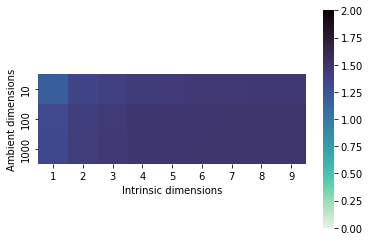

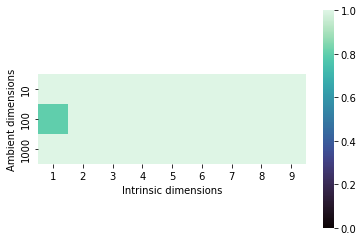

In [62]:
k = g.apply(mse).unstack().fillna(0)
sns.heatmap(k.reset_index().pivot_table(index='Ambient dimensions',
                        columns='Intrinsic dimensions',
                        values='Sliced MI'), square=True, cmap='mako_r',
            cbar=1,
            vmin=0, vmax=2)
plt.show()
k = g.apply(kendall).unstack().fillna(0)
sns.heatmap(k.reset_index().pivot_table(index='Ambient dimensions',
                        columns='Intrinsic dimensions',
                        values='Sliced MI'), square=True, cmap='mako',
            cbar=1,
            vmin=0, vmax=1)
plt.show()
# axn.flat[5].remove()